In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import umap
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import pyarrow as pa
from pyarrow import csv
from utils import clean_tweets, get_length_info, get_cls_embeddings, aggregate_embeddings, process_and_merge_embeddings

seed = 42
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

# No Processing

Here we just tokenize and embedd, without touching the dataset at all.

## Training Set

In [3]:
li_train = []
matchid_to_filename = {}

for filename in os.listdir("data/train_tweets"):
    df_temp = pd.read_csv(f"data/train_tweets/{filename}")
    li_train.append(df_temp)
    unique_match_ids = df_temp['MatchID'].unique()
    for match_id in unique_match_ids:
        matchid_to_filename[match_id] = filename

df_train = pd.concat(li_train, ignore_index=True)

In [3]:
df_train

,ID,MatchID,PeriodID,EventType,Timestamp,Tweet
0,11_0,11,0,0,1404575400000,RT @2014WorIdCup: Argentina vs Belgium\n\nWho ...
1,11_0,11,0,0,1404575400000,@elijahman_ time to focus on Belgium winning t...
2,11_0,11,0,0,1404575400000,RT @FIFAWorldCup: GLOBAL STADIUM: #Joinin with...
3,11_0,11,0,0,1404575400000,RT @CatholicNewsSvc: #PopeFrancis. Uh-oh. Arge...
4,11_0,11,0,0,1404575400000,RT @soccerdotcom: If he scores vs #BEL we'll a...
...,...,...,...,...,...,...
5056045,18_129,18,129,0,1276876799000,RT @nytimes FIFA World Cup -- Final Score: U.S...
5056046,18_129,18,129,0,1276876799000,Ugh!!! should've been 3-2 USA! #worldcup
5056047,18_129,18,129,0,1276876799000,RT @jaclynkeough: Ha! RT @someecards I'd rathe...
5056048,18_129,18,129,0,1276876799000,RT @gustavaulia: So many surprises at worldcup...


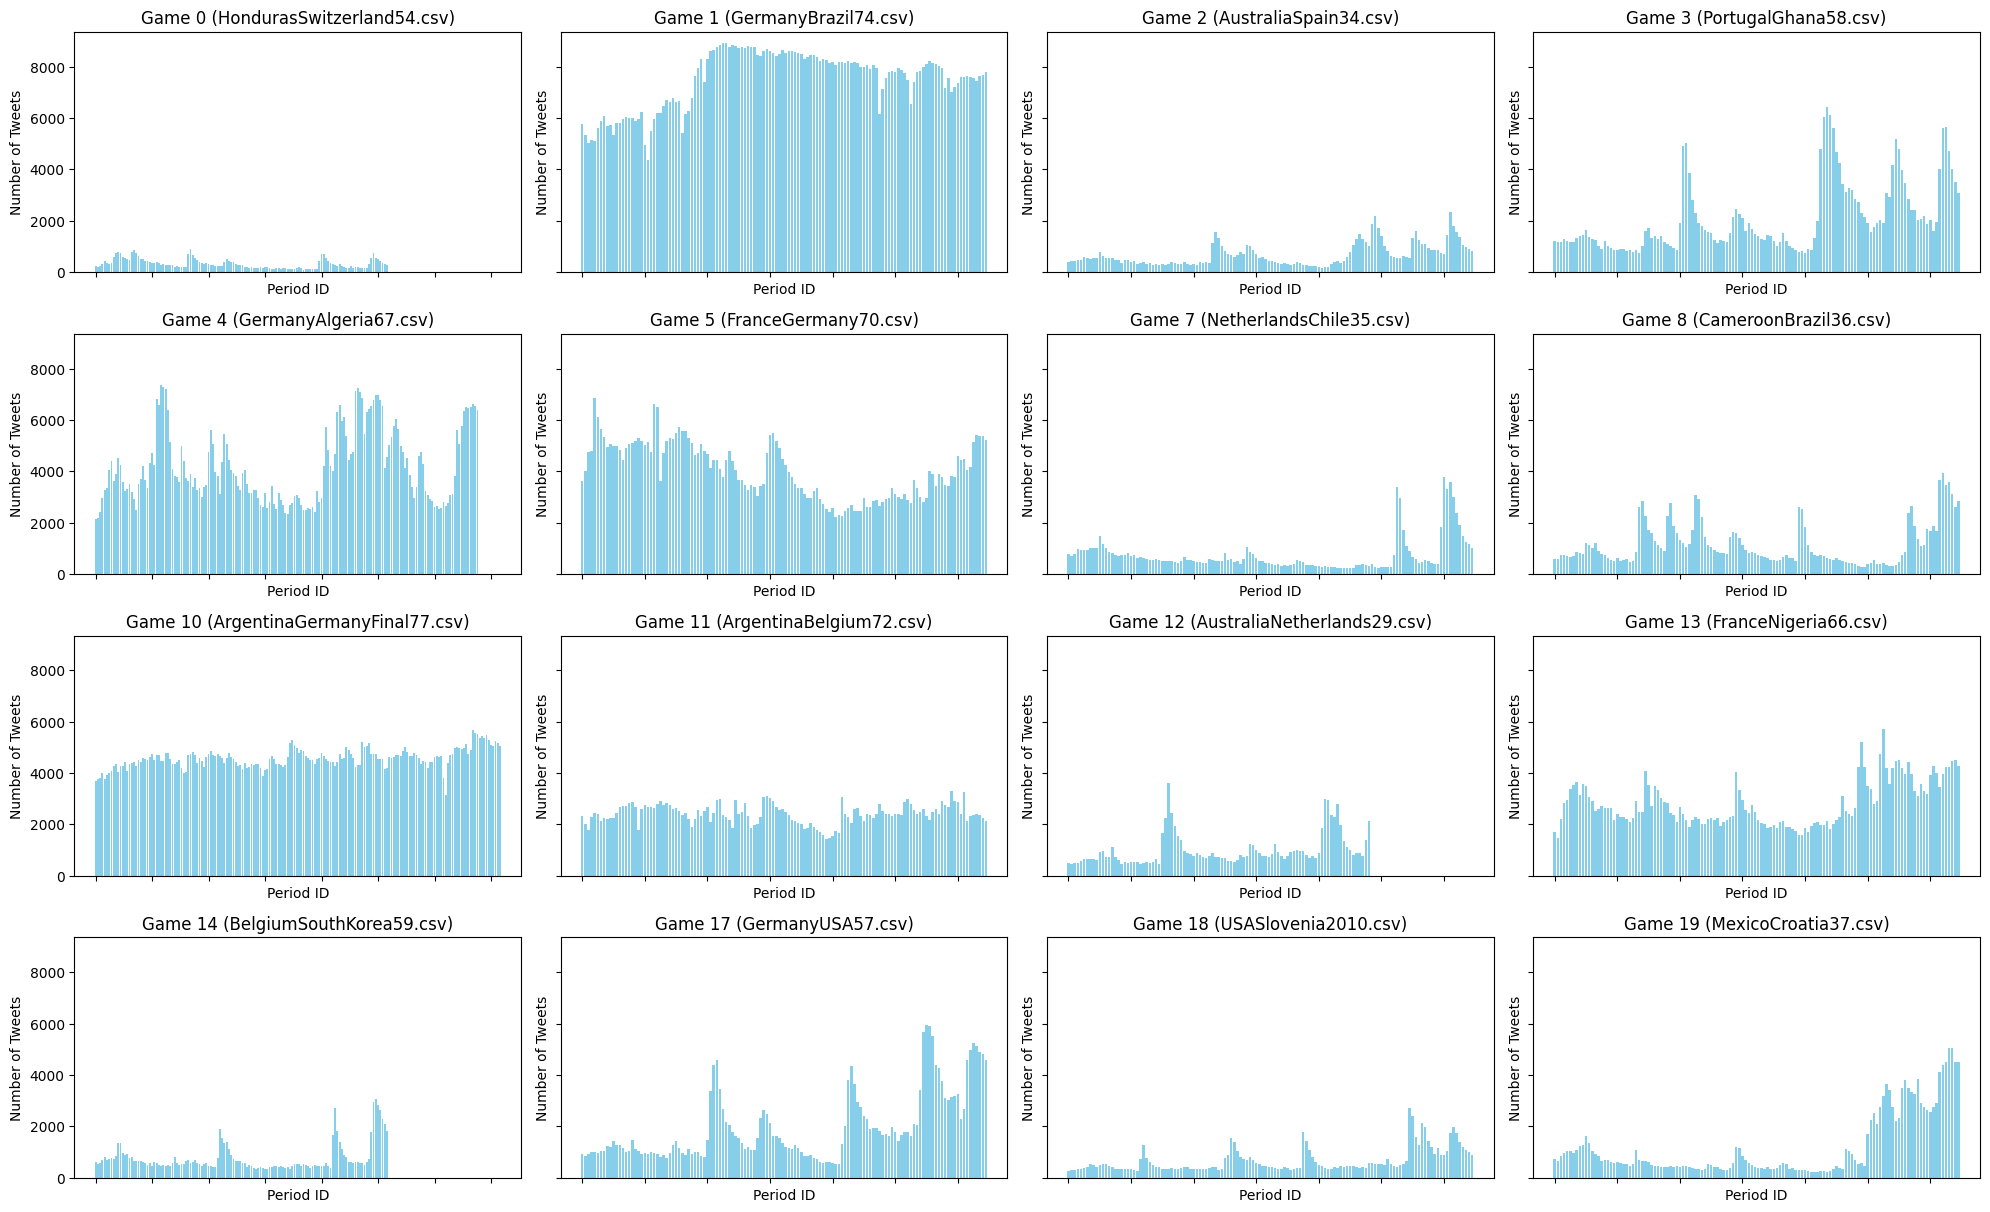

In [4]:
tweet_counts = df_train.groupby(['MatchID', 'PeriodID']).size().reset_index(name='TweetCount')
match_ids = tweet_counts['MatchID'].unique()
rows, cols = 4, 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex="col", sharey=True)
axes = axes.flatten()

for ax, match_id in zip(axes, match_ids):
    match_data = tweet_counts[tweet_counts['MatchID'] == match_id]
    file_name = matchid_to_filename.get(match_id, "Unknown")
    ax.bar(match_data['PeriodID'], match_data['TweetCount'], color='skyblue')
    ax.set_title(f'Game {match_id} ({file_name})')
    ax.set_xlabel('Period ID')
    ax.set_ylabel('Number of Tweets')

plt.tight_layout()
plt.show()

In [5]:
print(f"Total number of periods in the train set: {len(df_train['ID'].unique())}")
print(f"Max number of periods in a game in the train set: {len(df_train['PeriodID'].unique())}")

Total number of periods in the train set: 2137
Max number of periods in a game in the train set: 180


In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 257
  Average length: 27.06
  50th percentile length: 26.00
  75th percentile length: 37.00
  90th percentile length: 43.00
  95th percentile length: 47.00
  99th percentile length: 53.00


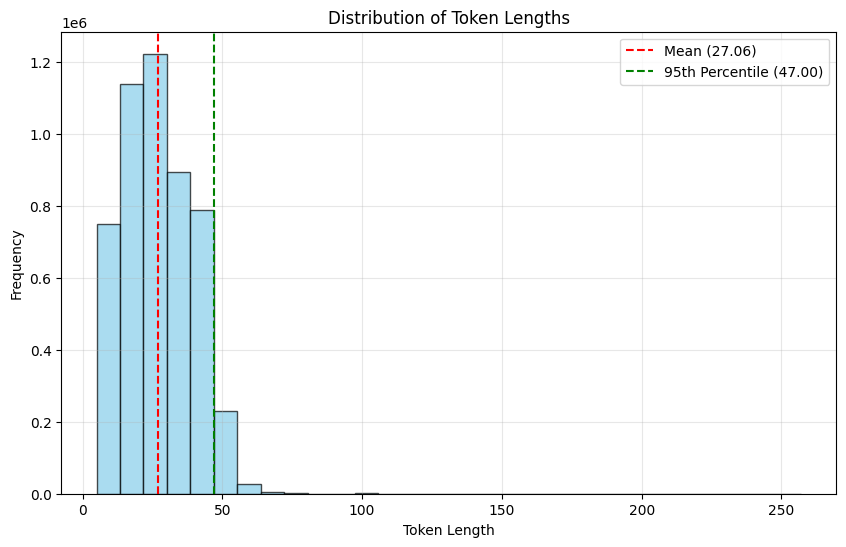

In [5]:
get_length_info(series=df_train["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

Let's choose 50 as our max length (checked also on test set below)

In [7]:
tokens = tokenizer(df_train["Tweet"].to_list(), max_length=50, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [ ]:
torch.save((tokens['input_ids'], tokens['attention_mask']), "tokens/bertweet.pt")

In [3]:
# input_ids, attention_masks = torch.load("tokens/bertweet.pt")

C:\Users\sandr\AppData\Local\Temp\ipykernel_2288\671276624.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_ids, attention_masks = torch.load("tokens/bertweet.pt")


In [10]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'])
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [11]:
final_cls_embeddings = get_cls_embeddings(model, dataloader, device)
assert final_cls_embeddings.shape == (df_train.shape[0], 768)

100%|██████████| 158002/158002 [4:57:54<00:00,  8.84it/s]  


Done!


In [12]:
df_train['cls'] = list(final_cls_embeddings.numpy())

In [ ]:
aggregated_embeddings, merged_df = process_and_merge_embeddings(
    df=df_train,
    cls_column='cls',
    id_column='ID',
    event_column='EventType',
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_embeddings_with_labels.pkl"
)

Saving merged DataFrame as pkl in aggregated_embeddings_with_labels.pkl
Saved!


In [14]:
merged_df

,ID,aggregated_embedding,EventType
0,0_0,"[0.038894046, 0.2056955, 0.1732219, -0.0507800...",0
1,0_1,"[0.049072143, 0.20504853, 0.16913632, -0.04101...",0
2,0_10,"[-0.010199165, 0.19084008, 0.142129, -0.027013...",1
3,0_100,"[0.1076907, 0.18990463, 0.13662358, -0.0059914...",1
4,0_101,"[0.110753596, 0.21662608, 0.14855266, -0.02414...",1
...,...,...,...
2132,8_95,"[-0.12547426, 0.10333069, 0.012717849, 0.00890...",0
2133,8_96,"[-0.13536794, 0.08814793, 0.013134736, -0.0146...",1
2134,8_97,"[-0.13311367, 0.09247862, 0.016269028, 0.00072...",1
2135,8_98,"[-0.12481897, 0.07730664, 0.014376387, 0.00727...",0


The vectors are already normalized.

## Test Set

We repeat the same.

In [6]:
li_test = []
matchid_to_filename_test = {}

for filename in os.listdir("data/eval_tweets"):
    df_temp = pd.read_csv(f"data/eval_tweets/{filename}")
    li_test.append(df_temp)
    unique_match_ids_val = df_temp['MatchID'].unique()
    for match_id in unique_match_ids_val:
        matchid_to_filename_test[match_id] = filename

df_test = pd.concat(li_test, ignore_index=True)

In [37]:
df_test

,ID,MatchID,PeriodID,Timestamp,Tweet
0,6_0,6,0,1403376600000,I Finally get to see Germany play\n#GER 🇩🇪⚽🏆
1,6_0,6,0,1403376600000,RT @Wor1dCup2014: If Any of the Boateng Brothe...
2,6_0,6,0,1403376600000,Fascinated for this #GERvsGHA match. This will...
3,6_0,6,0,1403376600000,: #GER and #GHA in a few.
4,6_0,6,0,1403376600000,BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...
...,...,...,...,...,...
1072923,15_125,15,125,1404064800000,Dutch deserve to be in last 8.Keep their nerve...
1072924,15_125,15,125,1404064800000,RT @GeniusFootball: RETWEET if you think #MEX ...
1072925,15_125,15,125,1404064800000,"Hold your head high Mexico, played beautifully..."
1072926,15_125,15,125,1404064800000,RT @TheWorIdCup: Mexico fans right now... http...


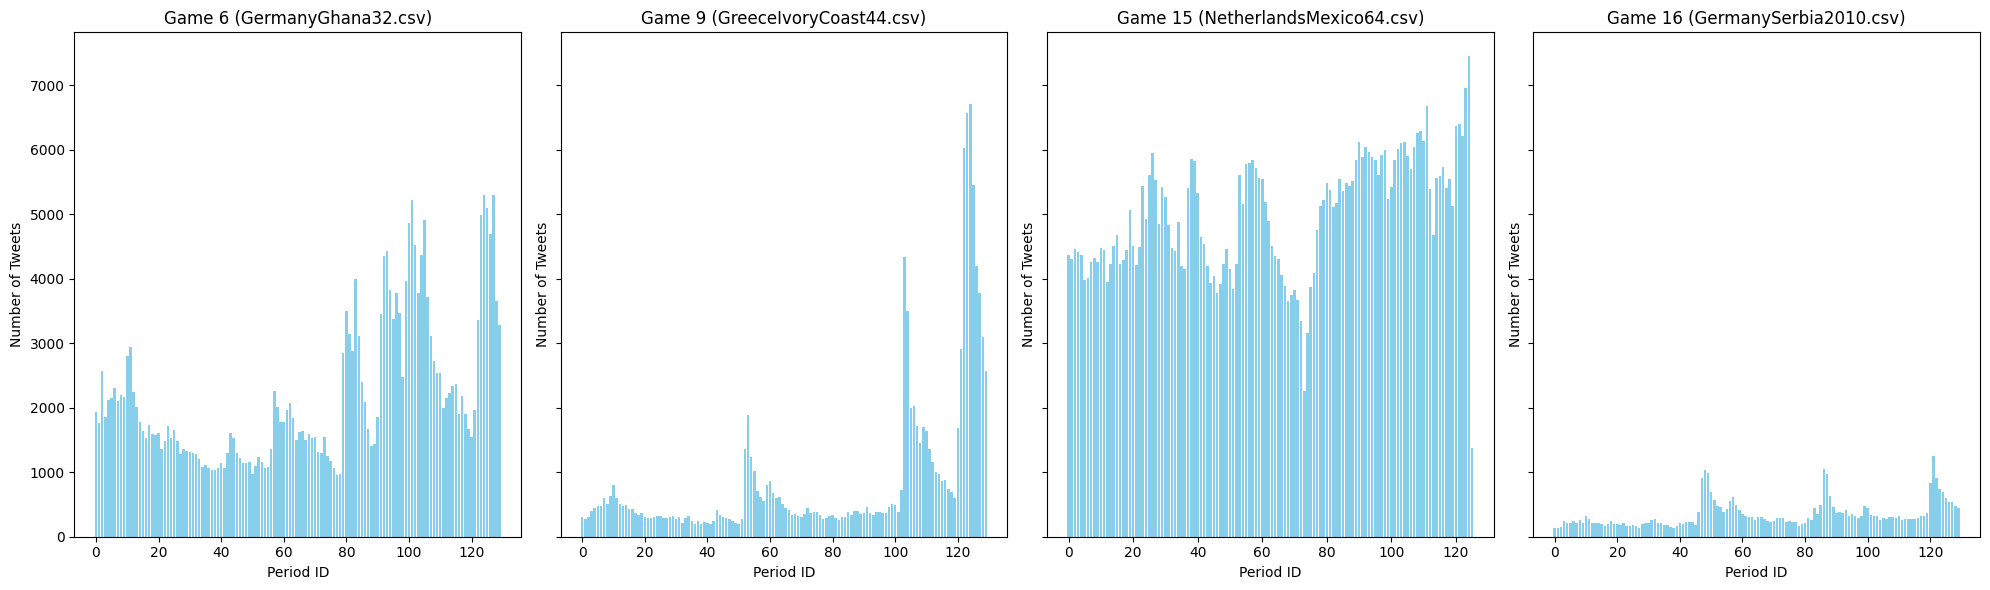

In [38]:
tweet_counts = df_test.groupby(['MatchID', 'PeriodID']).size().reset_index(name='TweetCount')
match_ids = tweet_counts['MatchID'].unique()
rows, cols = 1, 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 6), sharex="col", sharey=True)
axes = axes.flatten()

for ax, match_id in zip(axes, match_ids):
    match_data = tweet_counts[tweet_counts['MatchID'] == match_id]
    file_name = matchid_to_filename_test.get(match_id, "Unknown")
    ax.bar(match_data['PeriodID'], match_data['TweetCount'], color='skyblue')
    ax.set_title(f'Game {match_id} ({file_name})')
    ax.set_xlabel('Period ID')
    ax.set_ylabel('Number of Tweets')

plt.tight_layout()
plt.show()

In [39]:
print(f"Total number of periods in the train set: {len(df_test['ID'].unique())}")
print(f"Max number of periods in a game in the train set: {len(df_test['PeriodID'].unique())}")

Total number of periods in the train set: 516
Max number of periods in a game in the train set: 130


In [7]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 257
  Average length: 26.93
  50th percentile length: 26.00
  75th percentile length: 36.00
  90th percentile length: 43.00
  95th percentile length: 46.00
  99th percentile length: 54.00


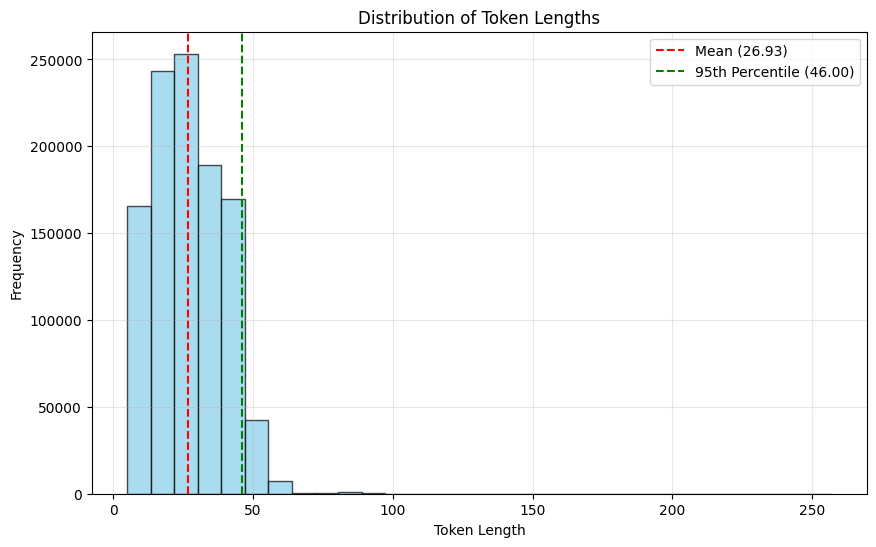

In [8]:
get_length_info(series=df_test["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

In [41]:
tokens_test = tokenizer(df_test["Tweet"].to_list(), max_length=50, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [ ]:
torch.save((tokens_test['input_ids'], tokens_test['attention_mask']), "tokens/bertweet_test.pt")

In [ ]:
# input_ids_test, attention_masks_test = torch.load("tokens/bertweet_test.pt")

In [44]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset_test = TensorDataset(tokens_test['input_ids'], tokens_test['attention_mask'])
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [45]:
final_cls_embeddings_test = get_cls_embeddings(model, dataloader_test, device)
assert final_cls_embeddings_test.shape == (df_test.shape[0], 768)

100%|██████████| 33529/33529 [1:03:17<00:00,  8.83it/s]


Done!


In [46]:
df_test['cls'] = list(final_cls_embeddings_test.numpy())

In [48]:
df_test

,ID,MatchID,PeriodID,Timestamp,Tweet,cls
0,6_0,6,0,1403376600000,I Finally get to see Germany play\n#GER 🇩🇪⚽🏆,"[0.077867225, 0.09731847, 0.059819218, -0.1415..."
1,6_0,6,0,1403376600000,RT @Wor1dCup2014: If Any of the Boateng Brothe...,"[-0.063964926, 0.14290993, 0.0746815, -0.16638..."
2,6_0,6,0,1403376600000,Fascinated for this #GERvsGHA match. This will...,"[0.24081214, 0.13553065, 0.030091574, -0.20579..."
3,6_0,6,0,1403376600000,: #GER and #GHA in a few.,"[0.26232398, 0.018381672, -0.0555337, -0.11693..."
4,6_0,6,0,1403376600000,BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...,"[0.10413483, 0.13103765, 0.013799746, 0.014316..."
...,...,...,...,...,...,...
1072923,15_125,15,125,1404064800000,Dutch deserve to be in last 8.Keep their nerve...,"[0.06866108, 0.15437774, 0.2838874, -0.1459453..."
1072924,15_125,15,125,1404064800000,RT @GeniusFootball: RETWEET if you think #MEX ...,"[-0.025768155, 0.14188139, 0.12810758, -0.0807..."
1072925,15_125,15,125,1404064800000,"Hold your head high Mexico, played beautifully...","[-0.021281535, 0.27584612, 0.21054737, -0.0213..."
1072926,15_125,15,125,1404064800000,RT @TheWorIdCup: Mexico fans right now... http...,"[-0.16251707, 0.20360164, 0.09227639, -0.07586..."


In [ ]:
aggregated_embeddings_test, merged_df_test = process_and_merge_embeddings(
    df=df_test,
    cls_column='cls',
    id_column='ID',
    event_column="MatchID", # just put as a placeholder
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_embeddings_with_labels_test.pkl"
)

Saving merged DataFrame as pkl in aggregated_embeddings_with_labels_test.pkl
Saved!


In [51]:
merged_df_test

,ID,aggregated_embedding,MatchID
0,15_0,"[-0.005626861, 0.17002444, 0.1560707, -0.07122...",15
1,15_1,"[-0.012398133, 0.16987626, 0.15416442, -0.0715...",15
2,15_10,"[-0.0063685165, 0.17705764, 0.14571677, -0.061...",15
3,15_100,"[-0.028167112, 0.21267831, 0.11889246, -0.0327...",15
4,15_101,"[-0.021408508, 0.20869574, 0.12005638, -0.0342...",15
...,...,...,...
511,9_95,"[-0.06389925, 0.15774356, 0.10894526, -0.06712...",9
512,9_96,"[-0.06254904, 0.16254315, 0.10645582, -0.07547...",9
513,9_97,"[-0.06544371, 0.15834767, 0.1077392, -0.078381...",9
514,9_98,"[-0.061433755, 0.15302086, 0.0968332, -0.06357...",9


## Data Visualization

Let's visualize our embeddings.

In [72]:
X = np.vstack(merged_df["aggregated_embedding"].values)
y = merged_df["EventType"].values

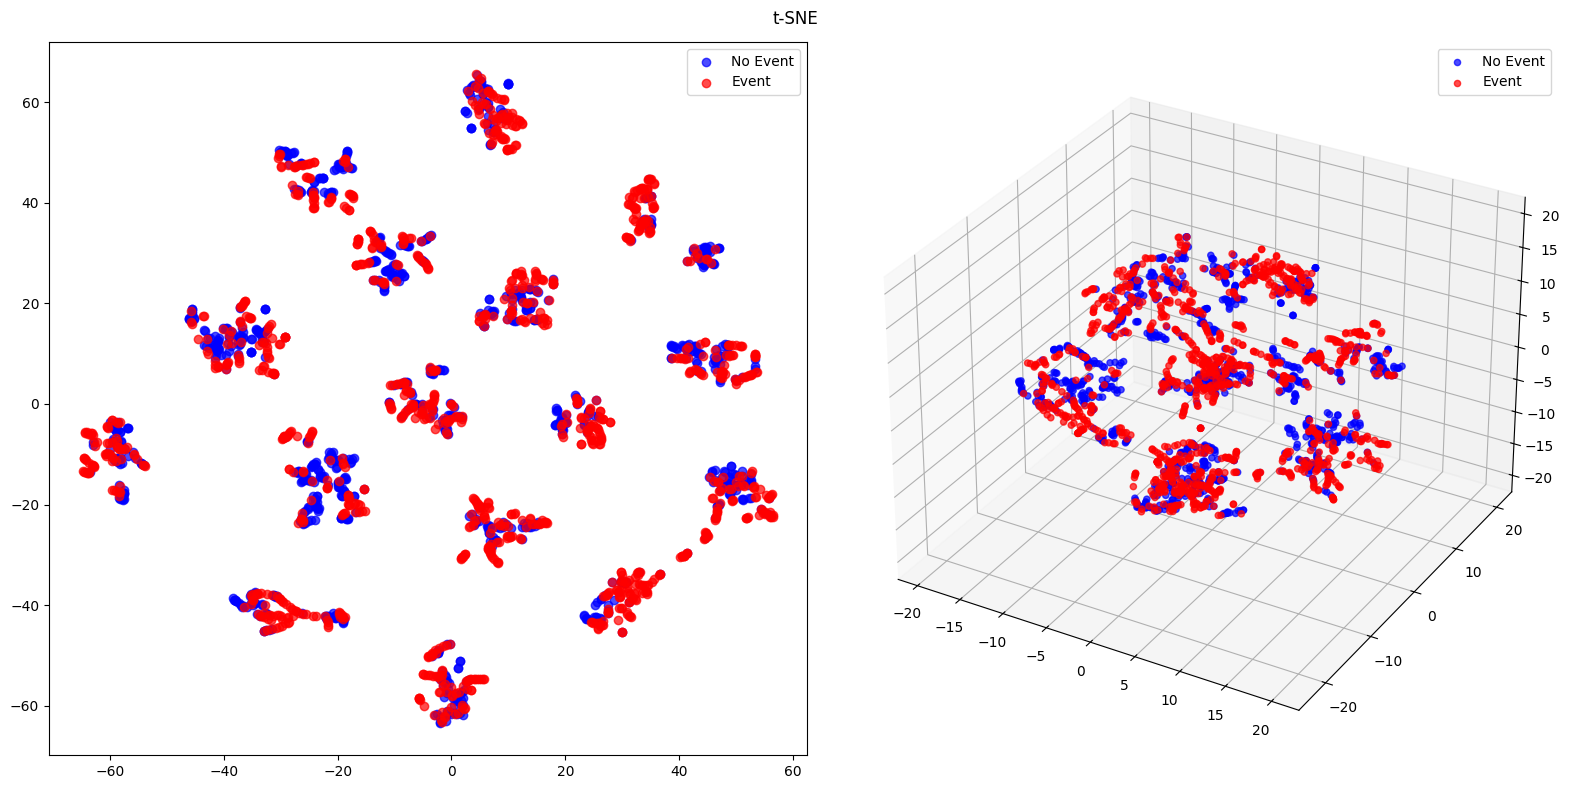

In [73]:
tsne2d = TSNE(n_components=2, random_state=seed)
reduced_embeddings2d = tsne2d.fit_transform(X)
tsne3d = TSNE(n_components=3, random_state=seed)
reduced_embeddings3d = tsne3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("t-SNE")
plt.tight_layout()
plt.show()

c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


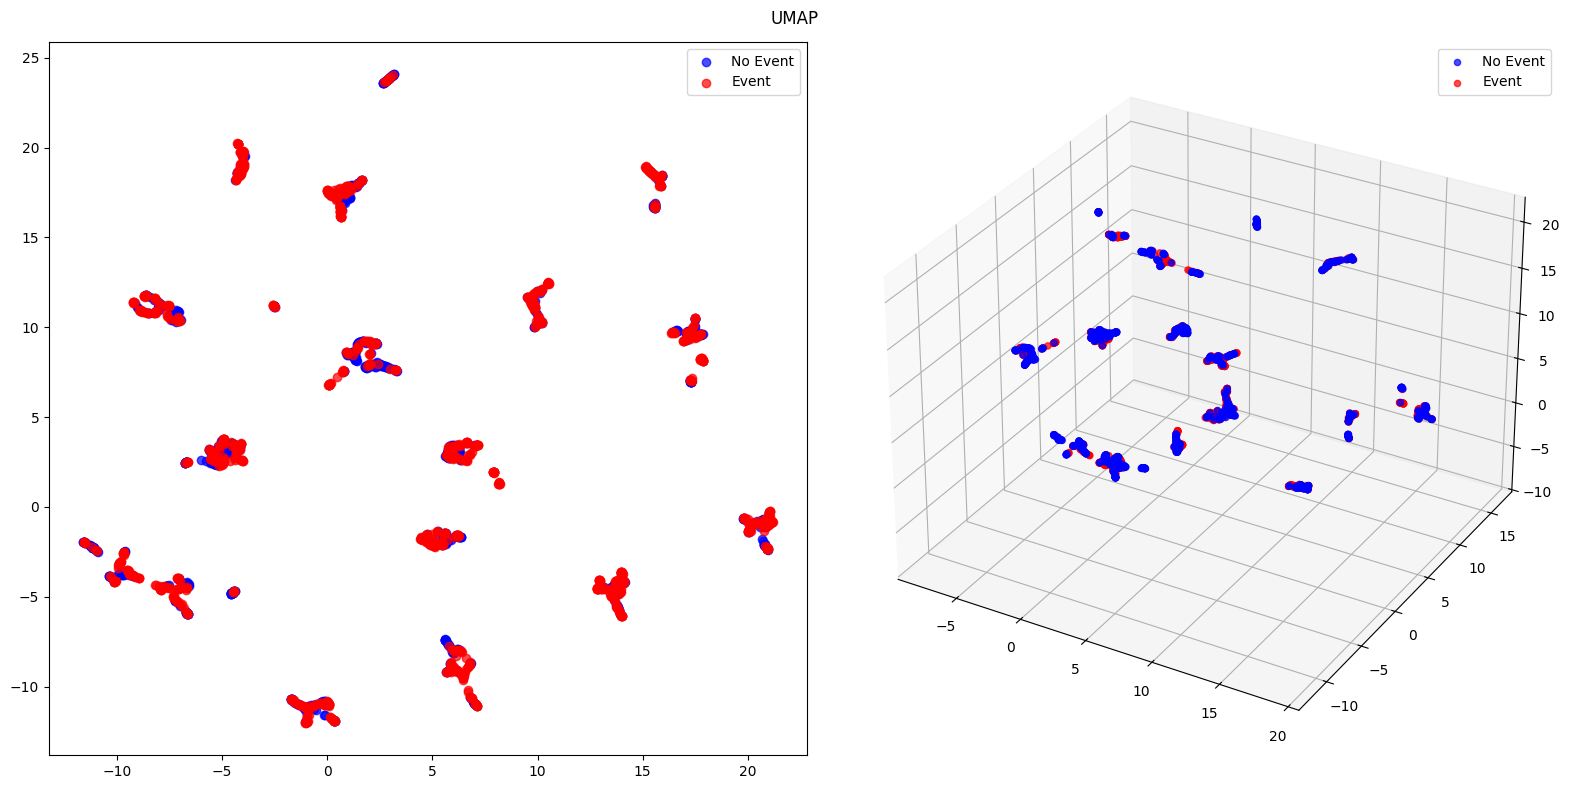

In [76]:
umap2d = umap.UMAP(n_components=2, random_state=seed)
reduced_embeddings2d = umap2d.fit_transform(X)
umap3d = umap.UMAP(n_components=3, random_state=seed)
reduced_embeddings3d = umap3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("UMAP")
plt.tight_layout()
plt.show()

Each game is clustered. The 2D and 3D plots are too low-dimensional to efficiently portray the separation between the positive and negative class. This is a suggestion for improving preprocessing to better distinguish the two classes, e.g. remove bad tweets (random, retweets), change embedding, constrative learning, feature engineering, etc.

# Preprocessing

Here we try to clean the data.

## Training Set

In [2]:
li_train = []
matchid_to_filename = {}

for filename in tqdm(os.listdir("data/train_tweets"), desc="Processing Files"):
    df_temp = pd.read_csv(f"data/train_tweets/{filename}")
    df_temp = clean_tweets(df_temp, column_name="Tweet", replace_teams=True, remove_one_word_tweets=False)
    li_train.append(df_temp)
    unique_match_ids = df_temp['MatchID'].unique()
    for match_id in unique_match_ids:
        matchid_to_filename[match_id] = filename

df_train = pd.concat(li_train, ignore_index=True)

Processing Files: 100%|██████████| 16/16 [13:05<00:00, 49.11s/it]


In [3]:
df_train

,ID,MatchID,PeriodID,EventType,Timestamp,Tweet
0,11_0,11,0,0,1404575400000,@elijahman_ time to focus on <team_2> winning ...
1,11_0,11,0,0,1404575400000,i just hope <team_1> lose. would be fun to see...
2,11_0,11,0,0,1404575400000,watch <team_1> vs <team_2> 5th july 2014 live ...
3,11_0,11,0,0,1404575400000,@jrmun0z why dont you like <team_1>.
4,11_0,11,0,0,1404575400000,even though i hate <team_2> for beating the us...
...,...,...,...,...,...,...
2371693,18_129,18,129,0,1276876799000,"ok, so <team> has to tie and not score more th..."
2371694,18_129,18,129,0,1276876799000,but that was a real soccer match after so many...
2371695,18_129,18,129,0,1276876799000,@heykolls no! <team_1> worldcup :)
2371696,18_129,18,129,0,1276876799000,woah. that was an awesome game of soccer just ...


In [4]:
df_train["EventType"].value_counts(normalize=True)

EventType
1    0.57349
0    0.42651
Name: proportion, dtype: float64

In [5]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 257
  Average length: 25.20
  50th percentile length: 23.00
  75th percentile length: 32.00
  90th percentile length: 40.00
  95th percentile length: 45.00
  99th percentile length: 52.00


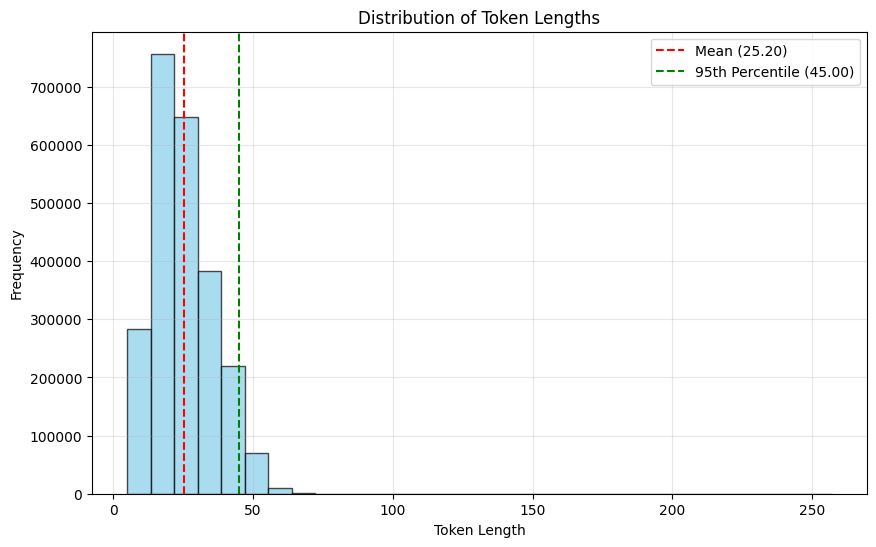

In [6]:
get_length_info(series=df_train["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

In [7]:
tokens = tokenizer(df_train["Tweet"].to_list(), max_length=50, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [8]:
torch.save((tokens['input_ids'], tokens['attention_mask']), "tokens/bertweet_processed2_no_teams.pt")

In [9]:
# input_ids, attention_masks = torch.load("tokens/bertweet_processed2_no_teams.pt")

In [10]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'])
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [11]:
final_cls_embeddings = get_cls_embeddings(model, dataloader, device)
assert final_cls_embeddings.shape == (df_train.shape[0], 768)

100%|██████████| 74116/74116 [2:18:22<00:00,  8.93it/s]  


Done!


In [12]:
df_train['cls'] = list(final_cls_embeddings.numpy())

In [14]:
# csv.write_csv(pa.Table.from_pandas(df_train), "df_processed2_no_teams_embedding_per_tweet.csv")

In [15]:
aggregated_embeddings, merged_df = process_and_merge_embeddings(
    df=df_train,
    cls_column='cls',
    id_column='ID',
    event_column='EventType',
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_processed2_no_teams_embeddings_with_labels.pkl"
)

Saving merged DataFrame as pkl in processed_data/aggregated_processed2_no_teams_embeddings_with_labels.pkl
Saved!


In [16]:
merged_df

,ID,aggregated_embedding,EventType
0,0_0,"[0.113946006, 0.25405857, 0.16819511, -0.08124...",0
1,0_1,"[0.12009395, 0.26731277, 0.16090168, -0.075128...",0
2,0_10,"[0.080117695, 0.2617985, 0.16096576, -0.055389...",1
3,0_100,"[0.090920724, 0.26141953, 0.14952163, -0.04513...",1
4,0_101,"[0.07735666, 0.26382214, 0.15831298, -0.050265...",1
...,...,...,...
2132,8_95,"[0.04423167, 0.25001833, 0.124842525, -0.04715...",0
2133,8_96,"[0.045176312, 0.2502851, 0.12884046, -0.059398...",1
2134,8_97,"[0.060056362, 0.24012491, 0.13202657, -0.04622...",1
2135,8_98,"[0.03901225, 0.24715461, 0.11884401, -0.045139...",0


## Test Set

In [17]:
li_test = []
matchid_to_filename_test = {}

for filename in tqdm(os.listdir("data/eval_tweets"), desc="Processing Files"):
    df_temp = pd.read_csv(f"data/eval_tweets/{filename}")
    df_temp = clean_tweets(df_temp, column_name="Tweet", replace_teams=True, remove_one_word_tweets=True)
    li_test.append(df_temp)
    unique_match_ids_val = df_temp['MatchID'].unique()
    for match_id in unique_match_ids_val:
        matchid_to_filename_test[match_id] = filename

df_test = pd.concat(li_test, ignore_index=True)

Processing Files: 100%|██████████| 4/4 [02:48<00:00, 42.24s/it]


In [18]:
df_test

,ID,MatchID,PeriodID,Timestamp,Tweet
0,6_0,6,0,1403376600000,i finally get to see <team_1> playger 🇩🇪⚽🏆
1,6_0,6,0,1403376600000,fascinated for this gervsgha match. this will ...
2,6_0,6,0,1403376600000,: <team_1> and <team_2> in a few.
3,6_0,6,0,1403376600000,boateng grudge match: 21/2 for jermaine to sco...
4,6_0,6,0,1403376600000,our players jooo <team_1> worldcup2014
...,...,...,...,...,...
522401,15_125,15,125,1404064800000,<team_1> what a team ! ochoa world cup goal ke...
522402,15_125,15,125,1404064800000,harsh on <team_1> though! <team_1>
522403,15_125,15,125,1404064800000,dutch deserve to be in last 8.keep their nerve...
522404,15_125,15,125,1404064800000,"hold your head high <team_1>, played beautiful..."


In [19]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 255
  Average length: 24.63
  50th percentile length: 23.00
  75th percentile length: 31.00
  90th percentile length: 40.00
  95th percentile length: 44.00
  99th percentile length: 53.00


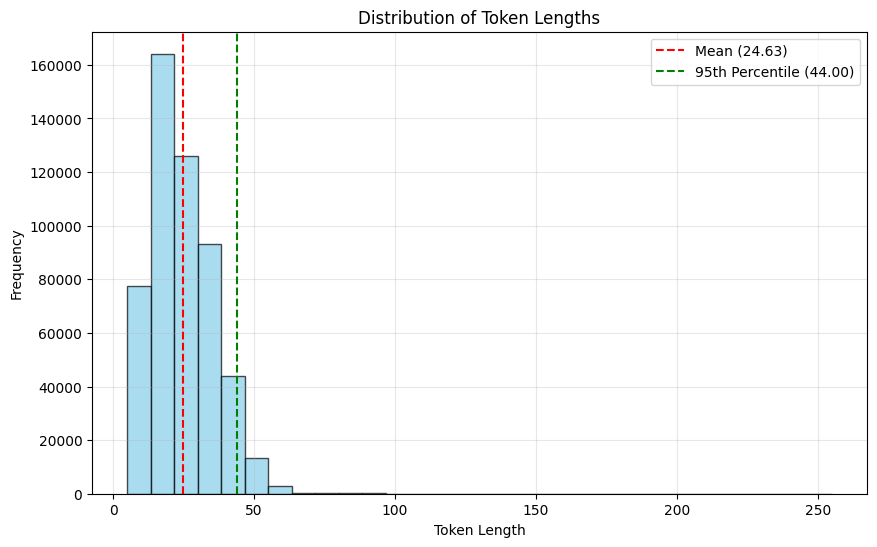

In [20]:
get_length_info(series=df_test["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

In [21]:
tokens_test = tokenizer(df_test["Tweet"].to_list(), max_length=50, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [22]:
torch.save((tokens_test['input_ids'], tokens_test['attention_mask']), "tokens/bertweet_processed2_no_teams_test.pt")

In [23]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset_test = TensorDataset(tokens_test['input_ids'], tokens_test['attention_mask'])
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [24]:
final_cls_embeddings_test = get_cls_embeddings(model, dataloader_test, device)
assert final_cls_embeddings_test.shape == (df_test.shape[0], 768)

100%|██████████| 16326/16326 [29:44<00:00,  9.15it/s]


Done!


In [25]:
df_test['cls'] = list(final_cls_embeddings_test.numpy())

In [26]:
# csv.write_csv(pa.Table.from_pandas(df_test), "df_processed2_no_teams_embedding_per_tweet_test.csv")

In [27]:
aggregated_embeddings_test, merged_df_test = process_and_merge_embeddings(
    df=df_test,
    cls_column='cls',
    id_column='ID',
    event_column="MatchID", # just put as a placeholder
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_processed2_no_teams_embeddings_with_labels_test.pkl"
)

Saving merged DataFrame as pkl in processed_data/aggregated_processed2_no_teams_embeddings_with_labels_test.pkl
Saved!


In [28]:
merged_df_test

,ID,aggregated_embedding,MatchID
0,15_0,"[0.035253562, 0.23655745, 0.16431181, -0.07380...",15
1,15_1,"[0.03411878, 0.23766541, 0.1651518, -0.0725717...",15
2,15_10,"[0.03397343, 0.24619274, 0.15815593, -0.066160...",15
3,15_100,"[0.032807227, 0.25758964, 0.13975443, -0.06406...",15
4,15_101,"[0.022793747, 0.25055176, 0.14461406, -0.06714...",15
...,...,...,...
511,9_95,"[0.021518555, 0.23988654, 0.14205514, -0.06648...",9
512,9_96,"[0.023369381, 0.2511798, 0.12941337, -0.068324...",9
513,9_97,"[0.02505665, 0.24075839, 0.13532451, -0.064753...",9
514,9_98,"[0.027225649, 0.23875152, 0.13362586, -0.06027...",9


## Data Visualization

In [29]:
file_path = "processed_data/aggregated_processed2_no_teams_embeddings_with_labels.pkl"
merged_df = pd.read_pickle(file_path)
X = np.vstack(merged_df["aggregated_embedding"].values)
y = merged_df["EventType"].values

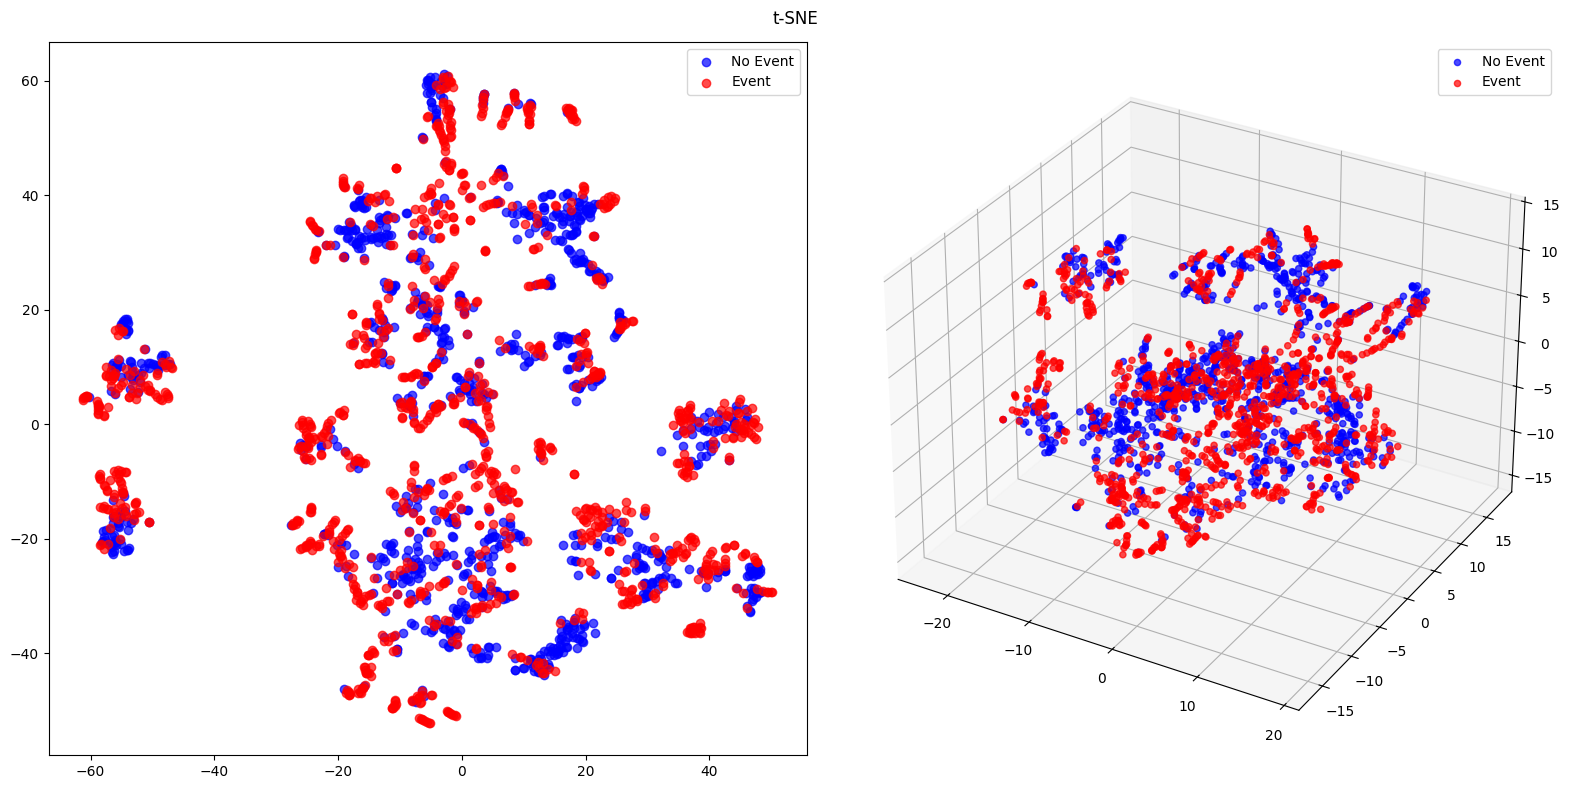

In [30]:
tsne2d = TSNE(n_components=2, random_state=seed)
reduced_embeddings2d = tsne2d.fit_transform(X)
tsne3d = TSNE(n_components=3, random_state=seed)
reduced_embeddings3d = tsne3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("t-SNE")
plt.tight_layout()
plt.show()

c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


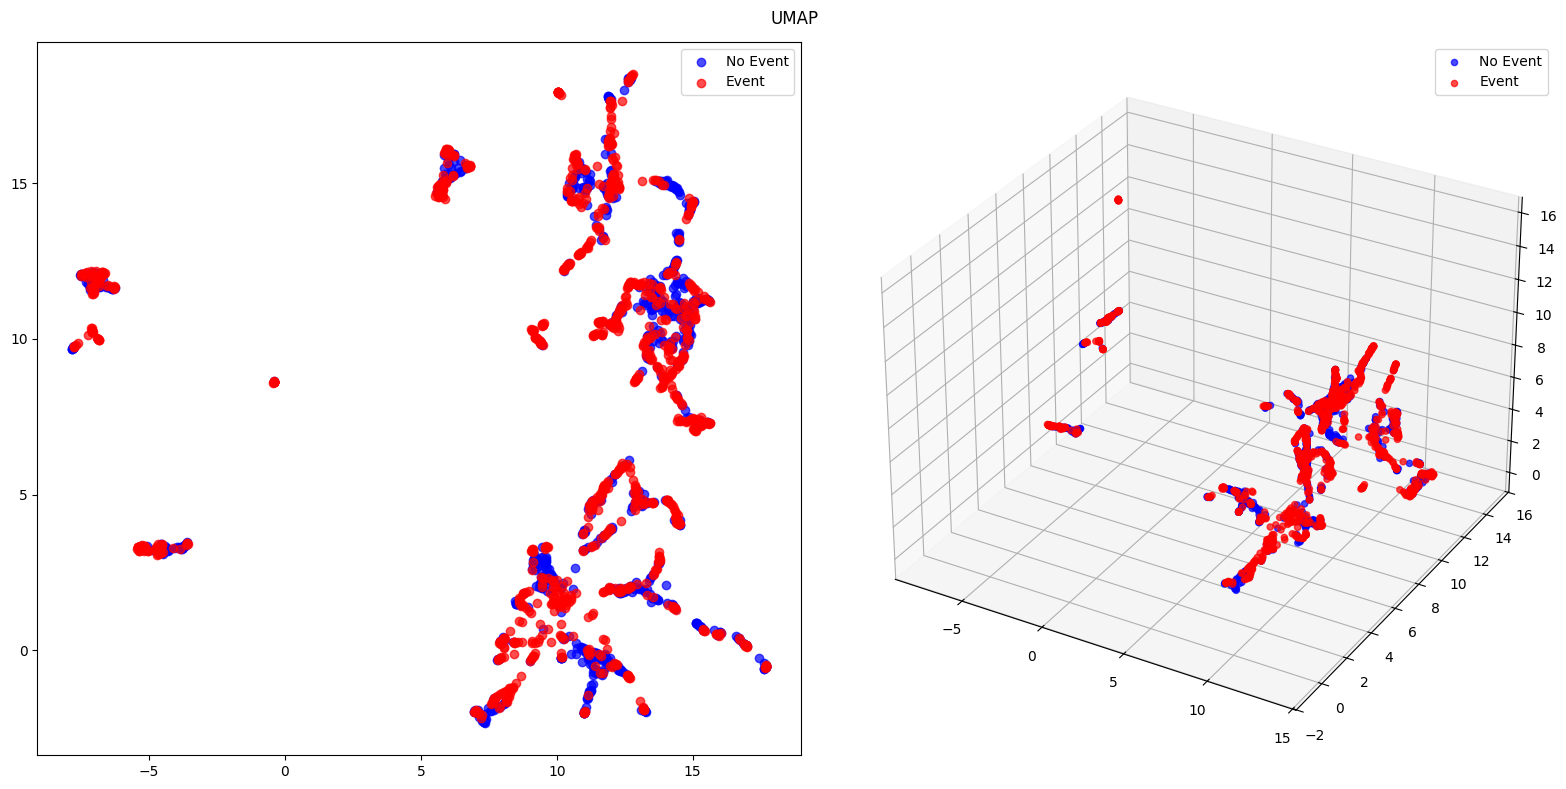

In [31]:
umap2d = umap.UMAP(n_components=2, random_state=seed)
reduced_embeddings2d = umap2d.fit_transform(X)
umap3d = umap.UMAP(n_components=3, random_state=seed)
reduced_embeddings3d = umap3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("UMAP")
plt.tight_layout()
plt.show()

Now it seems like the event and non-event periods are a bit more separable.

# Preprocessing with Similarity Aggregation

## Training Set

In [107]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity

def process_and_merge_embeddings_by_similarity(df, cls_column="cls", event_type_column="EventType", id_column="ID", output_format=None, output_path=None):
    """
    Aggregates embeddings per ID and merges the result with unique event-related data.

    Args:
        df (pd.DataFrame): The input DataFrame containing embeddings and labels.
        cls_column (str): The name of the column containing individual embeddings (e.g., 'cls').
        event_type_column (str): The name of the column containing labels (e.g., 'EventType').
        id_column (str): The name of the column used for grouping (e.g., 'ID').
        output_format (str, optional): The format to save the output ('csv' or 'pkl'). Defaults to None.
        output_path (str, optional): The path to save the output file. Required if `output_format` is specified.

    Returns:
        pd.DataFrame: A merged DataFrame containing aggregated embeddings and associated labels.
        
    Raises:
        ValueError: If `output_path` is not provided when `output_format` is specified.
        ValueError: If an invalid `output_format` is provided.
    """
    id_aggregated_embeddings = []

    # Group by ID
    id_groups = df.groupby(id_column)

    for unique_id, id_samples in id_groups:
        # Group the ID data by EventType
        event_type_groups = id_samples.groupby(event_type_column)
        event_type_aggregations = []
        total_tweets_in_id = len(id_samples)

        for event_type, event_type_samples in event_type_groups:
            # Extract embeddings for the current event type
            embeddings = np.vstack(event_type_samples[cls_column])  # (N, D)

            # Compute the reference embedding (mean)
            reference_embedding = np.mean(embeddings, axis=0)

            # Compute cosine similarities with the reference embedding
            similarities = cosine_similarity(embeddings, reference_embedding.reshape(1, -1)).flatten()

            # Normalize similarities using softmax to get attention weights
            attention_weights = torch.softmax(torch.tensor(similarities), dim=0).numpy()

            # Compute weighted aggregation for this event type
            weighted_aggregation = np.dot(attention_weights, embeddings)

            # Store the weighted aggregation with its contribution weight (based on size)
            event_type_aggregations.append((weighted_aggregation, len(embeddings)))

        # Combine weighted aggregations from all event types
        final_id_embedding = sum(
            (event_size / total_tweets_in_id) * event_embedding
            for event_embedding, event_size in event_type_aggregations
        )
        id_aggregated_embeddings.append({"ID": unique_id, "aggregated_embedding": final_id_embedding})

    # Convert to DataFrame
    aggregated_df = pd.DataFrame(id_aggregated_embeddings)

    # Merge with labels or unique event-related data
    merged_df = pd.merge(
        aggregated_df,
        df[[id_column, event_type_column]].drop_duplicates(),
        on=id_column,
        how="inner"
    )
    
    # save output if requested
    if output_format:
        if not output_path:
            raise ValueError("output_path must be specified if output_format is provided.")
        
        if output_format == 'csv':
            print(f"Saving merged DataFrame as {output_format} in {output_path}")
            merged_df.to_csv(output_path, index=False)
            print("Saved!")
        elif output_format == 'pkl':
            print(f"Saving merged DataFrame as {output_format} in {output_path}")
            merged_df.to_pickle(output_path)
            print("Saved!")
        else:
            raise ValueError("Invalid output_format. Choose 'csv' or 'pkl'.")
    
    return merged_df

In [115]:
merged_df = process_and_merge_embeddings_by_similarity(df_train,
                                                       cls_column="cls", event_type_column="EventType", id_column="ID",
                                                       output_format="pkl",
                                                       output_path="processed_data/similarity_aggregated_processed2_no_teams_embeddings_with_labels.pkl")

Saving merged DataFrame as pkl in processed_data/similarity_aggregated_processed2_no_teams_embeddings_with_labels.pkl
Saved!


In [116]:
merged_df

,ID,aggregated_embedding,EventType
0,0_0,"[0.113863185, 0.25399217, 0.16831651, -0.08117...",0
1,0_1,"[0.120237485, 0.2669787, 0.16120772, -0.075147...",0
2,0_10,"[0.07998199, 0.26179686, 0.1610382, -0.0552430...",1
3,0_100,"[0.09074174, 0.26145023, 0.14973955, -0.044975...",1
4,0_101,"[0.07723929, 0.26390603, 0.15838297, -0.050099...",1
...,...,...,...
2132,8_95,"[0.0442052, 0.25004005, 0.12509423, -0.0469851...",0
2133,8_96,"[0.045044363, 0.25035122, 0.1290281, -0.059350...",1
2134,8_97,"[0.05991027, 0.24008104, 0.13231327, -0.046415...",1
2135,8_98,"[0.03905512, 0.24726795, 0.11885731, -0.045002...",0


In [109]:
X = np.vstack(merged_df["aggregated_embedding"].values)
y = merged_df["EventType"].values

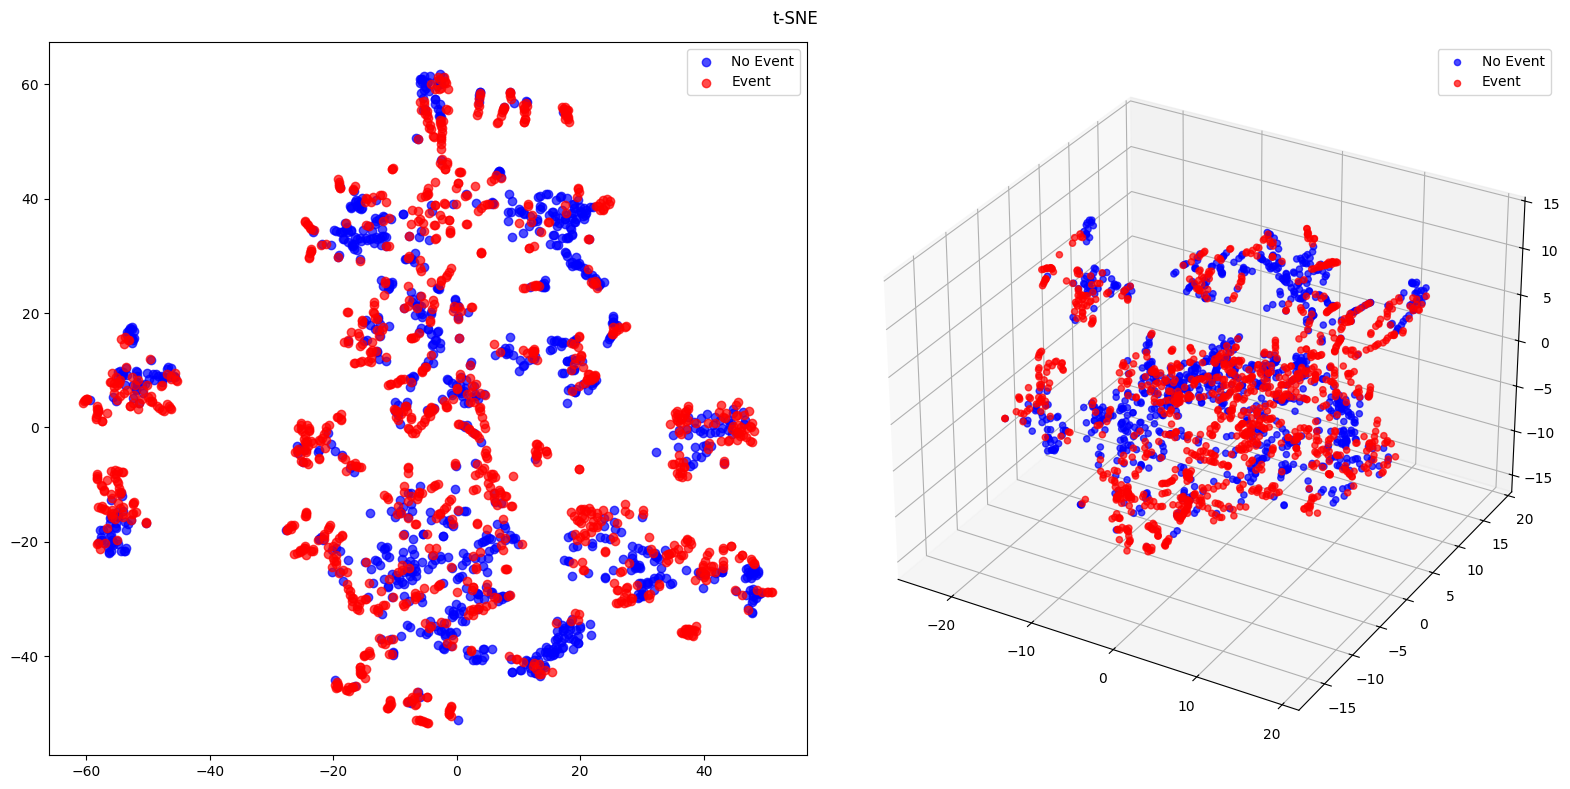

In [110]:
tsne2d = TSNE(n_components=2, random_state=seed)
reduced_embeddings2d = tsne2d.fit_transform(X)
tsne3d = TSNE(n_components=3, random_state=seed)
reduced_embeddings3d = tsne3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("t-SNE")
plt.tight_layout()
plt.show()

c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


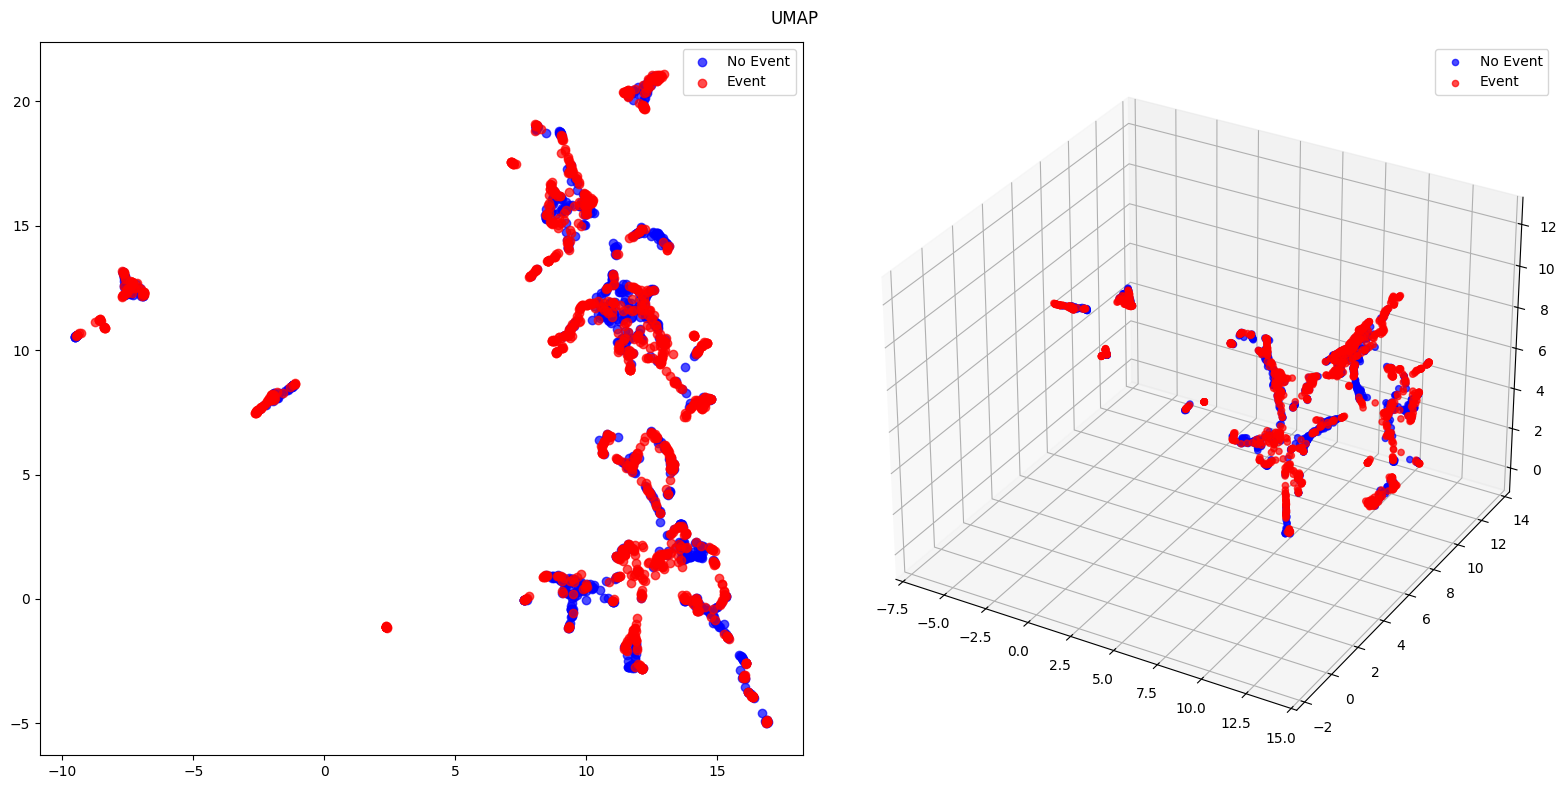

In [111]:
umap2d = umap.UMAP(n_components=2, random_state=seed)
reduced_embeddings2d = umap2d.fit_transform(X)
umap3d = umap.UMAP(n_components=3, random_state=seed)
reduced_embeddings3d = umap3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("UMAP")
plt.tight_layout()
plt.show()

## Test Set

In [119]:
merged_df_test = process_and_merge_embeddings_by_similarity(df_test,
                                                            cls_column="cls", event_type_column="MatchID", id_column="ID",
                                                            output_format="pkl",
                                                            output_path="processed_data/similarity_aggregated_processed2_no_teams_embeddings_with_labels_test.pkl")

merged_df_test

Saving merged DataFrame as pkl in processed_data/similarity_aggregated_processed2_no_teams_embeddings_with_labels_test.pkl
Saved!


,ID,aggregated_embedding,MatchID
0,15_0,"[0.035216145, 0.23670512, 0.16461788, -0.07351...",15
1,15_1,"[0.034069423, 0.23782559, 0.16553776, -0.07227...",15
2,15_10,"[0.03389384, 0.24631235, 0.15847614, -0.065858...",15
3,15_100,"[0.032782994, 0.25771907, 0.14000085, -0.06382...",15
4,15_101,"[0.022839505, 0.25066984, 0.14487386, -0.06689...",15
...,...,...,...
511,9_95,"[0.021239778, 0.2399597, 0.1421722, -0.0662935...",9
512,9_96,"[0.023016805, 0.2511774, 0.12957984, -0.068158...",9
513,9_97,"[0.02473588, 0.2408242, 0.13554707, -0.0646261...",9
514,9_98,"[0.02699592, 0.23885195, 0.13381645, -0.060118...",9
